In [54]:
# Library imports
import scipy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [55]:
def evaluate(t, y):
    NBodies = int(len(y)/6)
    accelerations = np.zeros(y.size)
    
    for i in range(NBodies):
        ioffset = i*6
        
        for j in range(NBodies):
            joffset = j*6
            accelerations[ioffset:ioffset+3] = y[ioffset+3:ioffset+6]
            
            if i != j:
                d = y[ioffset:ioffset+3] - y[joffset:joffset+3]
                r = np.sqrt(np.sum(d**2))
                a = d*G*masses[j]/(r**3)
                accelerations[ioffset+3:ioffset+6] += a
    
    return accelerations

In [56]:
def euler(t,dt,y,evaluate):
    k = dt * evaluate(t, y) 
    y_new = y + k
    
    return y_new

In [57]:
def getVelocities(y):
    NBodies = int(len(y)/6)
    velocities = np.zeros(y.size)
    
    for i in range(NBodies):
        ioffset = i*6
        
        for j in range(NBodies):
            joffset = j*6
            velocities[ioffset:ioffset+3] = y[ioffset+3:ioffset+6]
            
    return velocities

In [58]:
def getAcceleration(t, y): #Returns vector of 0 in v, a in acc
    NBodies = int(len(y)/6)
    accelerations = np.zeros(y.size)
    
    for i in range(NBodies):
        ioffset = i*6
        
        for j in range(NBodies):
            joffset = j*6
            accelerations[ioffset:ioffset+3] = 0
            
            if i != j:
                d = y[ioffset:ioffset+3] - y[joffset:joffset+3]
                r = np.sqrt(np.sum(d**2))
                a = d*G*masses[j]/(r**3)
                accelerations[ioffset+3:ioffset+6] += a
    
    return accelerations

In [59]:
def rk4(t,dt,y,evaluate):
    k1 = dt * evaluate(t, y) 
    k2 = dt * evaluate(t + 0.5*dt, y + 0.5*k1)
    k3 = dt * evaluate(t + 0.5*dt, y + 0.5*k2)
    k4 = dt * evaluate(t + dt, y + k3)
    
    y_new = y + (1/6.)*(k1+ 2*k2 + 2*k3 + k4)
    
    return y_new

In [60]:
def LeapFrog(t, dt, y):
    y_new = y + getAcceleration(t, y)*dt/2
    
    y_new =y_new + getVelocities(y_new) * dt
    
    y_new = y_new + getAcceleration(t, y_new)*dt/2
    
    return y_new

In [61]:
def AdamsBashforth(t,dt,y,evaluate):
    w0 = y[0]
    w1 = y[1]
    w2 = y[2]
    w3 = y[3]
    
    t0 = t - 4*dt
    t1 = t - 3*dt
    t2 = t - 2*dt
    t3 = t - dt
    
    w = w3 + (dt/24)*(55*evaluate(t3, w3) - 59*evaluate(t2, w2) + 37*evaluate(t1, w1) - 9*evaluate(t0, w0))
    
    return w

In [62]:
def AdamsMoulton(t,dt,y,evaluate):
    w1 = y[1]
    w2 = y[2]
    w3 = y[3]
    w4 = y[4]
    
    t1 = t - 3*dt
    t2 = t - 2*dt
    t3 = t - 1*dt
    t4 = t
    
    w4 = w3 + (dt/24)*(9*evaluate(t4, w4) + 19*evaluate(t3, w3) - 5*evaluate(t2, w2) + evaluate(t1, w1))
    
    return w4

In [63]:
def runRK4(T, dt, y0, masses, evaluate, t0 = 0):
    nsteps = int((T-t0)/dt)
    history = np.empty((nsteps+1, len(y0)))
    history[0, :] = y0
    
    t = t0
    for i in range(nsteps):
        history[i+1] = rk4(t, dt, history[i,:], evaluate) 
        t += dt
    
    return history

In [64]:
def runEuler(T, dt, y0, masses, evaluate, t0 = 0):
    nsteps = int((T-t0)/dt)
    history = np.empty((nsteps+1, len(y0)))
    history[0, :] = y0
    
    t = t0
    for i in range(nsteps):
        history[i+1] = euler(t, dt, history[i,:], evaluate) 
        t += dt
    
    return history

In [65]:
def runLeapFrog(T, dt, y0, masses, t0 = 0):
    nsteps = int((T-t0)/dt)
    history = np.empty((nsteps+1, len(y0)))
    history[0, :] = y0
    t = t0
    for i in range(nsteps):
        history[i+1] = LeapFrog(t, dt, history[i,:]) 
        t += dt

    return history

In [66]:
def runAB(T, dt, y0, masses, evaluate, t0 = 0):
    nsteps = int((T-t0)/dt)
    history = np.empty((nsteps+1, len(y0)))
    history[0, :] = y0
    
    t = t0
    for i in range(3):
        history[i+1] = rk4(t, dt, history[i,:], evaluate) 
        t += dt
        
    for i in range(3, nsteps):
        history[i+1] = AdamsBashforth(t, dt, history[i-3:i+1,:], evaluate) 
        t += dt
    
    return history

In [67]:
def runAM(T, dt, y0, masses, evaluate, historyAux, t0 = 0):
    nsteps = int((T-t0)/dt)
    history = np.empty((nsteps+1, len(y0)))
    history[0, :] = y0
    
    t = t0
    for i in range(3):
        history[i+1] = rk4(t, dt, history[i,:], evaluate) 
        t += dt
        
    for i in range(3, nsteps):
        history[i+1] = AdamsMoulton(t, dt, historyAux[i-3:i+2,:], evaluate) 
        t += dt
    
    return history

In [68]:
def runPredictorCorrector(T, dt, y0, masses, evaluate, t0 = 0):
    historyAB = runAB(T+dt, dt, y0, masses, evaluate)
    history = runAM(T, dt, y0, masses, evaluate, historyAB)
    return history

In [69]:
# Variable declaration 1 -> Earth and Sun
G = -6.67*(10**-11)
t0 = 0
T = 6.221e6
dt = 3600 
y0 = np.array([3.84e8, 0, 0, 0, 1000, 0,
               0, 0, 0, 0, 0, 0])
masses = np.array([7.347e22, 5.97e24])

In [70]:
# Variable declaration 2 -> Saturn, Janus and Epithemeus
G = -6.67*(10**-20)
t0 = 0
T = 6.221e6
dt = 360
y0 = np.array([0, 0, 0, 0, 0, 0,                                  #Saturn
               0.11e6, 0.93e5, -0.17e5, -0.99e1, 0.12e2, -0.8e-1, #Janus
              0.19e5, -0.14e6,0.15e5,0.16e2, 0.17e1, -0.15e1])    #Epithemeus
masses = np.array([5.68e26, 1.89e18, 5.26e17])

In [82]:
# Variable declaration 3 -> Solar system
G = -6.67*(10**-11)
t0 = 0
T = 6.221e8
dt = 36000
y0 = np.array([0,0,0,0,0,0,                                                                     #Sun
              -3.166e+011,6.696e+011,4.297e+009,-1.239e+004,-5.861e+003, 3.020e+002,            #Jupyter
              -1.210e+012,-5.941e+011,5.844e+010,4.487e+003,-9.141e+003,-18.731,                #Saturn
              -1.147e+012,-2.483e+012,5.772e+009,6.469e+003,-2.990e+003,-94.58104783662382,     #Uranus
              -4.451e+012, 2.582e+011,9.730e+010, -3.146e+002,-5.468e+003,1.196e+002,           #Neptune
              -4.215e+012, -5.323e+011, 1.276e+012, 8.805e+002, -6.035e+003, 3.912e+002])       #Pluto
masses = np.array([1.9891e30, 18986e23, 5684.6e23, 868.32e23, 1024.3e23, 0.1314e23])

In [76]:
# Variable declaration 4 -> figure 8
G = 1e-9
t0 = 0
T = 2
# dt = 0.0001
# y0 = np.array([0.97000436,-0.24308753,0,0.46620369,0.43236573,0,
#                0,0,0,-0.93240737,-0.86473146,0,
#                -0.97000436,0.24308753,0,0.46620369,0.43236573,0])
dt = 0.00001
y0 = np.array([0.97000436, -0.24308753, 0,  0.93240737/2, 0.86473146/2, 0,
                -0.97000436, 0.24308753,0, 0.93240737/2, 0.86473146/2, 0,
                0,0,0,-0.93240737,  -0.86473146,0])
masses = np.array([1, 1, 1])

In [83]:
# Calculation
historyRK4 = runRK4(T, dt, y0, masses, evaluate)
historyEuler = runEuler(T, dt, y0, masses, evaluate)
historyLF = runLeapFrog(T, dt, y0, masses)
historyAB = runAB(T, dt, y0, masses, evaluate)
historyPC = runPredictorCorrector(T, dt, y0, masses, evaluate)

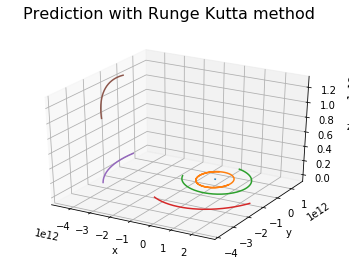

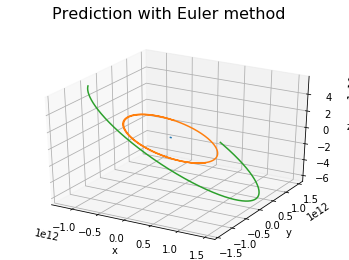

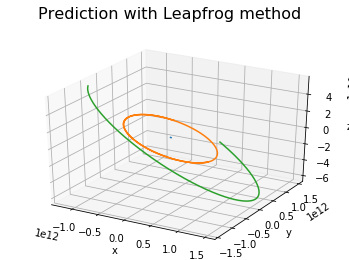

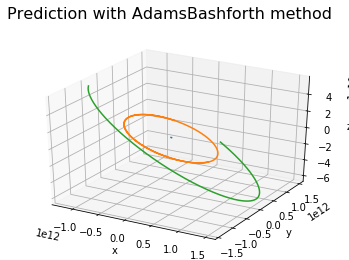

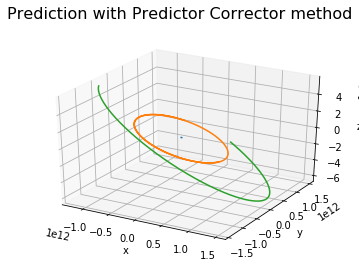

In [85]:
# Plot the results in 3d
fig = plt.figure()
fig.suptitle('Prediction with Runge Kutta method', fontsize=16)
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.plot3D(historyRK4[:,0], historyRK4[:,1], historyRK4[:,2])
ax.plot3D(historyRK4[:,6], historyRK4[:,7], historyRK4[:,8])
ax.plot3D(historyRK4[:,12], historyRK4[:,13], historyRK4[:,14])
ax.plot3D(historyRK4[:,18], historyRK4[:,19], historyRK4[:,20])
ax.plot3D(historyRK4[:,24], historyRK4[:,25], historyRK4[:,26])
ax.plot3D(historyRK4[:,30], historyRK4[:,31], historyRK4[:,32])

fig = plt.figure()
fig.suptitle('Prediction with Euler method', fontsize=16)
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.plot3D(historyEuler[:,0], historyEuler[:,1], historyEuler[:,2])
ax.plot3D(historyEuler[:,6], historyEuler[:,7], historyEuler[:,8])
ax.plot3D(historyEuler[:,12], historyEuler[:,13], historyEuler[:,14])

fig = plt.figure()
fig.suptitle('Prediction with Leapfrog method', fontsize=16)
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.plot3D(historyLF[:,0], historyLF[:,1], historyLF[:,2])
ax.plot3D(historyLF[:,6], historyLF[:,7], historyLF[:,8])
ax.plot3D(historyLF[:,12], historyLF[:,13], historyLF[:,14])

fig = plt.figure()
fig.suptitle('Prediction with AdamsBashforth method', fontsize=16)
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.plot3D(historyAB[:,0], historyAB[:,1], historyAB[:,2])
ax.plot3D(historyAB[:,6], historyAB[:,7], historyAB[:,8])
ax.plot3D(historyAB[:,12], historyAB[:,13], historyAB[:,14])

fig = plt.figure()
fig.suptitle('Prediction with Predictor Corrector method', fontsize=16)
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.plot3D(historyPC[:,0], historyPC[:,1], historyPC[:,2])
ax.plot3D(historyPC[:,6], historyPC[:,7], historyPC[:,8])
ax.plot3D(historyPC[:,12], historyPC[:,13], historyPC[:,14])

print()

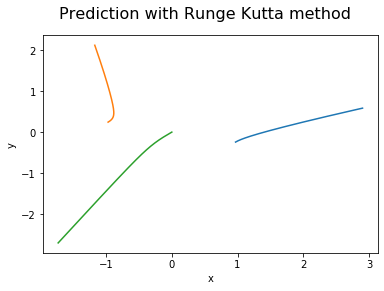

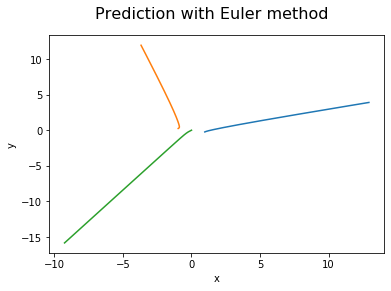

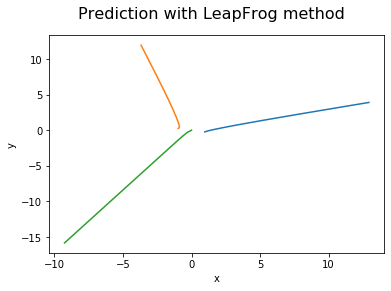

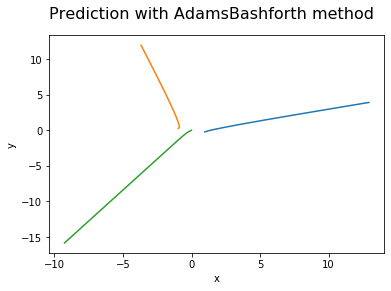

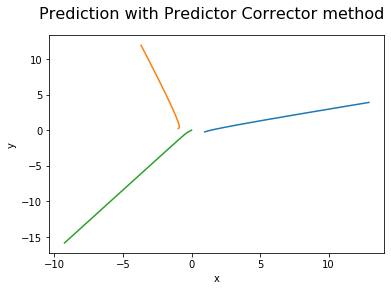

In [75]:
# Plot the results in 2d
fig = plt.figure()
fig.suptitle('Prediction with Runge Kutta method', fontsize=16)
ax = plt.axes()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(historyRK4[:,0], historyRK4[:,1])
ax.plot(historyRK4[:,6], historyRK4[:,7])
ax.plot(historyRK4[:,12], historyRK4[:,13])

fig = plt.figure()
fig.suptitle('Prediction with Euler method', fontsize=16)
ax = plt.axes()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(historyEuler[:,0], historyEuler[:,1])
ax.plot(historyEuler[:,6], historyEuler[:,7])
ax.plot(historyEuler[:,12], historyEuler[:,13])

fig = plt.figure()
fig.suptitle('Prediction with LeapFrog method', fontsize=16)
ax = plt.axes()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(historyLF[:,0], historyLF[:,1])
ax.plot(historyLF[:,6], historyLF[:,7])
ax.plot(historyLF[:,12], historyLF[:,13])

fig = plt.figure()
fig.suptitle('Prediction with AdamsBashforth method', fontsize=16)
ax = plt.axes()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(historyAB[:,0], historyAB[:,1])
ax.plot(historyAB[:,6], historyAB[:,7])
ax.plot(historyAB[:,12], historyAB[:,13])

fig = plt.figure()
fig.suptitle('Prediction with Predictor Corrector method', fontsize=16)
ax = plt.axes()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(historyPC[:,0], historyPC[:,1])
ax.plot(historyPC[:,6], historyPC[:,7])
ax.plot(historyPC[:,12], historyPC[:,13])

print()

In [ ]:
print(historyLF[1700,:4])
print(historyRK4[1700,:4])
print(historyEuler[1700,:4])
print(historyAB[1700,:4])
print(historyPC[1700,:4])